Initial Implementation of GP

Inspired by: https://peterroelants.github.io/posts/gaussian-process-tutorial/



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
# Define the RBF KERNEL serving as covariance function
def rbf_kernel(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [3]:
# Sample from the Gaussian process distribution
nb_of_samples = 10  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = rbf_kernel(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

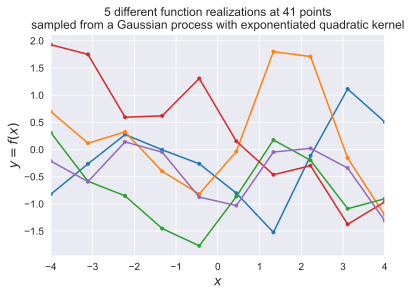

In [4]:
# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

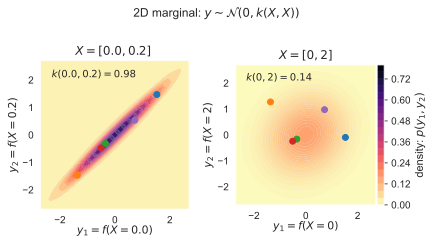

In [15]:
def generate_surface(mean, covariance, surface_resolution):
    """Helper function to generate density surface."""
    x1s = np.linspace(-5, 5, num=surface_resolution)
    x2s = np.linspace(-5, 5, num=surface_resolution)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((surface_resolution, surface_resolution))
    # Fill the cost matrix for each combination of weights
    for i in range(surface_resolution):
        for j in range(surface_resolution):
            pdf[i,j] = scipy.stats.multivariate_normal.pdf(
                np.array([x1[i,j], x2[i,j]]), 
                mean=mean, cov=covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

surface_resolution = 50  # Resolution of the surface to plot
fig = plt.figure(figsize=(6.2, 3.5)) 
gs = gridspec.GridSpec(1, 2)
ax_p1 = plt.subplot(gs[0,0])
ax_p2 = plt.subplot(gs[0,1], sharex=ax_p1, sharey=ax_p1)

# Plot of strong correlation
X_strong = np.array([[0], [0.2]])
μ = np.array([0., 0.])
Σ_strong = rbf_kernel(X_strong, X_strong)
y1, y2, p = generate_surface(μ, Σ_strong, surface_resolution=surface_resolution)
# Plot bivariate distribution
con1 = ax_p1.contourf(y1, y2, p, 25, cmap=cm.magma_r)
ax_p1.set_xlabel(
    f'$y_1 = f(X={X_strong[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p1.set_ylabel(
    f'$y_2 = f(X={X_strong[1,0]})$', 
    fontsize=11)
ax_p1.axis([-2.7, 2.7, -2.7, 2.7])
ax_p1.set_aspect('equal')
ax_p1.text(
    -2.3, 2.1, 
    (f'$k({X_strong[0,0]}, {X_strong[1,0]}) '
     f'= {Σ_strong[0,1]:.2f}$'), 
    fontsize=10)
ax_p1.set_title(
    f'$X = [{X_strong[0,0]}, {X_strong[1,0]}]$ ', 
    fontsize=12)
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_02_index = np.where(np.isclose(X, 0.2))
y_strong = ys[:,[X_0_index[0][0], X_02_index[0][0]]]
# Show samples on surface
for i in range(y_strong.shape[0]):
    ax_p1.plot(y_strong[i,0], y_strong[i,1], marker='o')

# Plot weak correlation
X_weak = np.array([[0], [2]])
μ = np.array([0., 0.])
Σ_weak = rbf_kernel(X_weak, X_weak)
y1, y2, p = generate_surface(μ, Σ_weak, surface_resolution=surface_resolution)
# Plot bivariate distribution
con2 = ax_p2.contourf(y1, y2, p, 25, cmap=cm.magma_r)
con2.set_cmap(con1.get_cmap())
con2.set_clim(con1.get_clim())
ax_p2.set_xlabel(
    f'$y_1 = f(X={X_weak[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p2.set_ylabel(
    f'$y_2 = f(X={X_weak[1,0]})$', 
    fontsize=11)
ax_p2.set_aspect('equal')
ax_p2.text(
    -2.3, 2.1, 
    (f'$k({X_weak[0,0]}, {X_weak[1,0]}) '
     f'= {Σ_weak[0,1]:.2f}$'), 
    fontsize=10)
ax_p2.set_title(
    f'$X = [{X_weak[0,0]}, {X_weak[1,0]}]$', 
    fontsize=12)
# Add colorbar
divider = make_axes_locatable(ax_p2)
cax = divider.append_axes('right', size='5%', pad=0.02)
cbar = plt.colorbar(con1, ax=ax_p2, cax=cax)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=11)
fig.suptitle('2D marginal: $y \sim \mathcal{N}(0, k(X, X))$')
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_2_index = np.where(np.isclose(X, 2.))
y_weak = ys[:,[X_0_index[0][0], X_2_index[0][0]]]
# Show samples on surface
for i in range(y_weak.shape[0]):
    ax_p2.plot(y_weak[i,0], y_weak[i,1], marker='o')

plt.tight_layout()
plt.show()


In [16]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [17]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

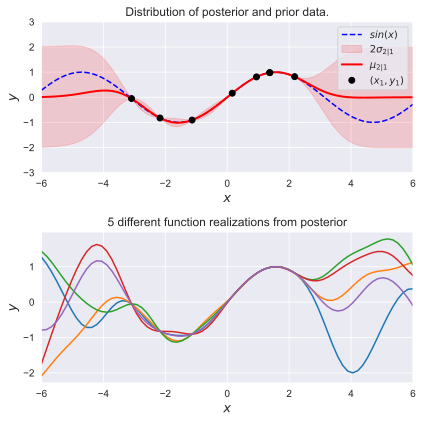

In [18]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [19]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [20]:
# Compute the posterior mean and covariance

σ_noise = 1.  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

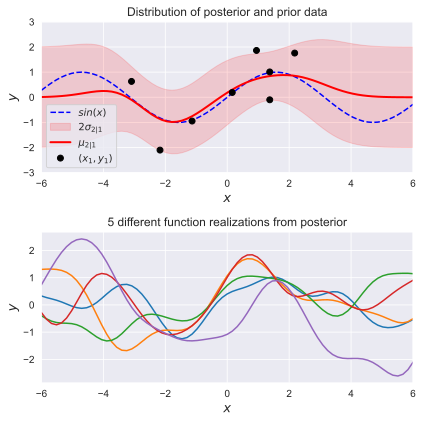

In [21]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#